<a href="https://colab.research.google.com/github/arnku/PML/blob/main/Exam/b2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from math import gamma
from torch.distributions.multivariate_normal import MultivariateNormal as TorchMVN
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.spatial
import scipy.optimize as opt
import pandas as pd

In [ ]:
from torch.distributions.multivariate_normal import MultivariateNormal as TorchMVN
import torch
class MVN:
    '''
    A light extension of the torch multivariate normal distribution to support a number of transformations of the normal distribution
    '''
    def __init__(self, mean, C,eps=1.e-4,L=None):
        '''
            Create a multivariate normal distribution x~N(mean,C) with given mean and covariance.

            eps is a jitter parameter that is added to the diagonal of C and prevents numerical problems when computing
            the cholesky decomposition. 1.e-8 is a good default for double precision.
        '''
        self.mean = mean
        if C is None and L is not None:
            self.L = L
        else:
            jitter = torch.eye(C.shape[0],dtype=C.dtype,device=C.device)*eps
            self.L = torch.linalg.cholesky(C+jitter,upper=False)
        self.dtype=self.L.dtype
        self.device=self.L.device
        self.torch_mvn = TorchMVN(self.mean, scale_tril=self.L)
    @property
    def covariance(self):
        ''' Returns the covariance of the MVN'''
        return self.L@self.L.T
    def log_prob(self, x):
        '''Returns the log-likelihood of a sample x'''
        return self.torch_mvn.log_prob(x)
    def sample(self, n_samples):
        '''
        Returns a n_samples x D array, where each row represents a sample from the MVN
        '''
        return self.torch_mvn.rsample([n_samples])
    def condition_upper(self, x_upper):
        '''
        Let x=(x_upper,x_lower). this function computes the MVN that is the conditional distribution
        x_lower|x_upper
        '''
        N_up = len(x_upper)
        L11 = self.L[:N_up,:N_up]
        L21 = self.L[N_up:,:N_up]
        L22 = self.L[N_up:,N_up:]
        y_upper = x_upper-self.mean[:N_up]

        eps_upper = torch.linalg.solve_triangular(L11, y_upper[:,None],upper=False,left=True)[:,0]
        new_mean = self.mean[N_up:] + L21@eps_upper
        return MVN(new_mean,C=None,L=L22)
    def transform(self, A, b, C_2=None):
        """
        Let x~MVN(m,C) and y~MVN(0,C_y). This function computes the MVN for z=Ax+b+y
        tha tis, z~MVN(Am+b,ACA^T+C_y)
        """
        Z = A@self.L
        mean_new = A@self.mean+b
        new_C = Z@Z.T
        #todo can be sped up if Z has same dimension as L and C_2=None
        if C_2 is not None:
            new_C = new_C + C_2
        return MVN(mean_new, C=new_C)


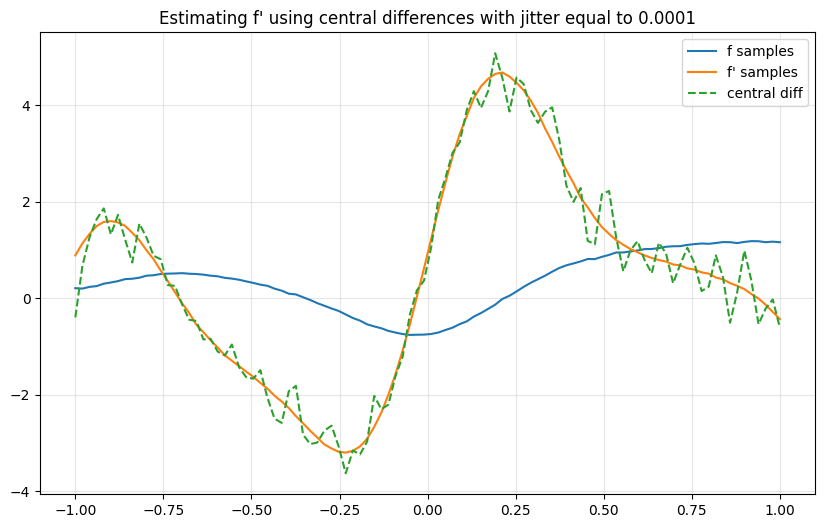

In [ ]:
device = 'cpu'
torch.set_default_dtype(torch.float64)


# Parameters
n = 100
gamma = 5.0
X = torch.linspace(-1, 1, n, device=device).unsqueeze(1)

# Pairwise differences
dX = X - X.T  # shape (n,n)

# Kernel and derivatives
K_XX = torch.exp(-gamma * dX**2)                 # K(x,x')
K_XdX = 2*gamma*dX*K_XX                        # dK/dx
KdX_X = K_XdX.T                                 # dK/dy
K_dXdX = (2*gamma - 4*gamma**2 * dX**2)*K_XX    # d²K/dxdy

# Build joint covariance
top = torch.cat([K_XX, K_XdX], dim=1)
bottom = torch.cat([KdX_X, K_dXdX], dim=1)
cov_joint = torch.cat([top, bottom], dim=0)
mean_joint = torch.zeros(2*n, device=device)

# Use the provided MVN implementation for numerical stability
eps=1e-4
mvn = MVN(mean_joint, cov_joint, eps=eps)

# Sample from the joint distribution
joint_sample = mvn.sample(1)
joint_sample = joint_sample.squeeze(0)  # Shape becomes [200]

#print samples

# Split f and f'
f_samples, f_prime_samples = torch.split(joint_sample, n, dim=0)

# Verify central difference
dx = (X[1] - X[0]).item()
f_prime_est = torch.zeros_like(f_samples)
f_prime_est[1:-1] = (f_samples[2:] - f_samples[:-2]) / (2 * dx)
f_prime_est[0] = (f_samples[1] - f_samples[0]) / dx
f_prime_est[-1] = (f_samples[-1] - f_samples[-2]) / dx


# Plot
plt.figure(figsize=(10, 6))
plt.plot(X.cpu(), f_samples.cpu(), label="f samples")
plt.plot(X.cpu(), f_prime_samples.cpu(), label="f' samples")
plt.plot(X.cpu(), f_prime_est.cpu(), '--', label="central diff")
plt.legend()
plt.grid(True, alpha=0.3)
plt.title(f"Estimating f' using central differences with jitter equal to {eps}")
plt.show()